# 0. Setup Environement

In [1]:
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA\ 301\ Advanced\ DS/final_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA 301 Advanced DS/final_project


In [2]:
%%capture
%pip install -r requirements.txt
%pip install wandb -Uq
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions
import torch
import wandb
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")

In [3]:
def get_best_torch_device():
    if torch.cuda.is_available():  # CUDA
        return "cuda"
    elif torch.backends.mps.is_available():  # Apple Silicon / GPU
        return "mps"
    else:  # Fallback to CPU
        return "cpu"

# 1. Data Loading & Configure Hyperparameters

In [4]:
# Configure hyperparameters (+ random state)
random_state = 13117
h_iter = 256
h_batch_size = 4096
h_test_size = 0.15
h_validation_size = 0.15
h_layers = 4
h_learning_rate = 0.001

device = get_best_torch_device()
print(f"Currently using {device.upper()} for training!")

Currently using CUDA for training!


In [5]:
label_data = pandas.read_csv("data/balanced_with_labels_v2.csv")

# Get rid of three-star reviews as it kinda confuses our algorithm
label_data = label_data[label_data["rating"] != 3]

# Shuffle data
label_data = label_data.sample(frac=1, random_state=random_state)
label_data.rename(columns={"Unnamed: 0" : "length"},inplace=True)
# Base on results from eye-balling the dataset,
# people seem to have a hard time giving intermediate (2 and 4) ratings,
# lets flat them.
# def get_flat_value(input_val):
#     if input_val <= 2:
#         return 1
#     elif input_val >= 3:
#         return 5

# label_data["rating"] = [get_flat_value(x) for x in label_data["rating"]]

display(label_data.head(10))
print(label_data.columns)

,length,review_text,rating,length,worst,okay,average,top-notch,satisfactory,below expectations,...,poor,good,outstanding,mediocre,commendable,acceptable,disappointing,excellent,above average,defective
43852,6858,"I Love it , the case came way earlier than I e...",5,167,0.000118,0.000773,0.000352,0.170489,0.066722,0.002396,...,0.000205,0.064828,0.118238,0.000281,0.047875,0.013985,0.000251,0.129232,0.023593,0.000170
49474,16997,Purchased a couple of these to have some backu...,5,134,0.000279,0.008049,0.000438,0.109011,0.132956,0.000585,...,0.000364,0.159151,0.076090,0.000454,0.051739,0.025226,0.000476,0.133450,0.025896,0.000317
49988,17938,"This is exactly as described, it fits on the 4...",5,319,0.000298,0.033936,0.001442,0.094081,0.224641,0.002623,...,0.000485,0.167467,0.045900,0.000749,0.058534,0.065348,0.000497,0.072379,0.022479,0.000406
11442,24748,I did not like the detachable lens because in ...,2,107,0.003923,0.002549,0.002179,0.002240,0.001669,0.079483,...,0.090445,0.004064,0.002290,0.022723,0.002280,0.002183,0.197969,0.001696,0.001991,0.082040
32803,13558,The product looks as advertised. The dock work...,4,208,0.000545,0.084155,0.005360,0.114425,0.125178,0.006628,...,0.002507,0.213531,0.012508,0.002183,0.033469,0.056006,0.038473,0.023701,0.031600,0.003428
39587,47635,Some cables I have been skeptical of because i...,4,163,0.000122,0.132858,0.005231,0.052803,0.147154,0.015131,...,0.000830,0.149270,0.019631,0.001982,0.081854,0.058517,0.000514,0.044522,0.059554,0.001638
19569,167672,"After using this case for several weeks, I wou...",2,222,0.004394,0.008581,0.013024,0.000499,0.001423,0.144771,...,0.093160,0.004454,0.000446,0.092779,0.000714,0.002078,0.106986,0.000420,0.001287,0.104478
6323,90592,Looks pretty but does not last very long. Very...,1,112,0.001509,0.017178,0.019331,0.000456,0.002528,0.163811,...,0.109466,0.003591,0.000537,0.122611,0.002190,0.002834,0.141044,0.000392,0.002520,0.041401
32461,11997,Battery over extends the device. The AC plug s...,4,625,0.000561,0.166334,0.041261,0.001369,0.112305,0.051571,...,0.017509,0.131220,0.003349,0.044215,0.019786,0.097497,0.008892,0.004881,0.042797,0.002677
34385,21566,Battery works great! I bought the battery befo...,4,1064,0.000381,0.070915,0.003922,0.050744,0.131416,0.005974,...,0.002854,0.229820,0.057702,0.003162,0.043856,0.046521,0.002028,0.121503,0.050549,0.001200


Index(['length', 'review_text', 'rating', 'length', 'worst', 'okay', 'average',
       'top-notch', 'satisfactory', 'below expectations', 'unsatisfactory',
       'bad', 'so-so', 'neutral', 'satisfying', 'amazing', 'impressive',
       'fantastic', 'poor', 'good', 'outstanding', 'mediocre', 'commendable',
       'acceptable', 'disappointing', 'excellent', 'above average',
       'defective'],
      dtype='object')


In [6]:
train_set, tmp_set = train_test_split(
    label_data, test_size=h_test_size + h_validation_size, random_state=random_state
)
test_set, validation_set = train_test_split(
    tmp_set,
    test_size=h_validation_size / (h_validation_size + h_test_size),
    random_state=random_state,
)
# train_set = label_data.sample(frac=1 - h_test_size, random_state=random_state)
# test_set = label_data.sample(frac=h_test_size, random_state=random_state)

In [7]:
class FairDataset(torch.utils.data.Dataset):
    def __init__(self, df_input):
        df_x = df_input[
            [
                c
                for c in df_input.columns
                if c not in ["review_text", "rating", "length"]
            ]
        ]
        df_y = df_input["rating"]
        self.features = torch.tensor(df_x.values, dtype=torch.float32).to(device)
        self.labels = torch.tensor(df_y.values, dtype=torch.float32).to(device)
        self.df_x = df_x
        self.df_y = df_y
        self.df_input = df_input

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [8]:
ds_train = FairDataset(train_set)
ds_test = FairDataset(test_set)
ds_validation = FairDataset(validation_set)

In [9]:
print("# of samples in train set:", len(ds_train))
print("# of samples in test set:", len(ds_test))
print("# of samples in validation set:", len(ds_validation))

# of samples in train set: 28000
# of samples in test set: 6000
# of samples in validation set: 6000


# 2. Define and Train Model

In [10]:
def spawn_layers(
    n_layers,
    input_size,
    output_size,
    is_batch_norm=True,
    activation_func=nn.ReLU,
    output_func=nn.LogSoftmax,
):
    layers = []
    prev_hidden = input_size

    for i in range(n_layers):
        hidden_size = int((prev_hidden + output_size) / 2)

        layers += [
            nn.Linear(in_features=prev_hidden, out_features=hidden_size),
            nn.BatchNorm1d(hidden_size) if is_batch_norm else nn.Identity(),
            activation_func(),
        ]

        prev_hidden = hidden_size

    return layers + [output_func(dim=1)]

In [11]:
sample_input, sample_output = ds_train[0]

input_size = len(sample_input)
output_size = len(str(sample_output))

In [14]:
columns = ["epoch", "train_loss", "val_loss", "val_accuracy","train_accuracy"]


loader_test = DataLoader(ds_test, batch_size=h_batch_size, shuffle=False)
loader_validation = DataLoader(ds_validation, batch_size=h_batch_size, shuffle=False)


def train_node(params):
    rows = []
    batch_size = params["batch_size"]
    n_layers = params["n_layers"]
    learning_rate = params["learning_rate"]
    n_epochs = params["n_epochs"]
    is_batch_norm = params["is_batch_norm"]

    optimizer_func = (
        torch.optim.Adam if params["optimizer"] == "adam" else torch.optim.SGD
    )
    activation_func = (
        nn.LeakyReLU if params["activation_func"] == "leaky_relu" else nn.ReLU
    )

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

    # Intialize Model
    model = nn.Sequential(
        *spawn_layers(
            n_layers,
            input_size,
            output_size,
            activation_func=activation_func,
            is_batch_norm=is_batch_norm,
        )
    ).to(device)

    # Initalize Optimizer (Adam in this case)
    optimizer = optimizer_func(model.parameters(), lr=learning_rate)

    # Initialize Loss Function
    criterion = nn.CrossEntropyLoss()

    best_val_loss = -1
    best_chkpt = None
    best_accuracy = -1

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode

        loss = None
        val_loss = None
        for inputs, labels in loader_train:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels.long())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        correct = 0
        total = 0

        # Get validation loss and accuracy
        with torch.no_grad():
            for inputs, labels in loader_validation:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels.long())

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_loss_num = val_loss.item()

        # Get training loss and accuracy
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader_train:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels.long())

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_accuracy = correct / total

        # Save the model with minimum val loss
        if best_val_loss == -1 or val_loss_num < best_val_loss:
            best_val_loss = val_loss_num
            best_accuracy = val_accuracy
            best_chkpt = {
                "params": params,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "input_size" : input_size,
                "output_size" : output_size,
                "input_columns" : ds_train.df_x.columns,
                "epoch": epoch,
                "loss": loss,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
                "train_accuracy": train_accuracy
            }

        # Print telemetry data
        print(
            f"\rEpoch [{epoch+1}/{n_epochs}] train_loss: {loss.item():.4f},"
            f"val_loss: {val_loss.item():.4f},"
            f"val_acc: {val_accuracy},"
            f"train_acc: {train_accuracy}",
            end="",
        )

        rows.append([epoch, loss.item(), val_loss.item(), val_accuracy,train_accuracy])

    df_results = pandas.DataFrame(rows, columns=columns)
    print("")

    return df_results, best_val_loss, best_accuracy, best_chkpt, model

In [15]:
h_optimizer = "adam"

h_iter = 128
h_batch_size = 8192
# h_test_size = 0.15
# h_validation_size = 0.15
h_layers = 4
h_learning_rate = 0.1

df_results, best_val_loss, best_accuracy, best_chkpt, model = train_node(
    {
        "batch_size": h_batch_size,
        "n_layers": h_layers,
        "learning_rate": h_learning_rate,
        "n_epochs": h_iter,
        "optimizer": h_optimizer,
        "is_batch_norm": True,
        "activation_func": "leaky_relu",
    }
)

torch.save(best_chkpt, "data/best_chkpt_final_4.pickle")

Epoch [128/128] train_loss: 0.7418,val_loss: 0.7844,val_acc: 0.6318333333333334,train_acc: 0.6358214285714285


Text(0.5, 1.0, 'Losses vs Number of Epochs')

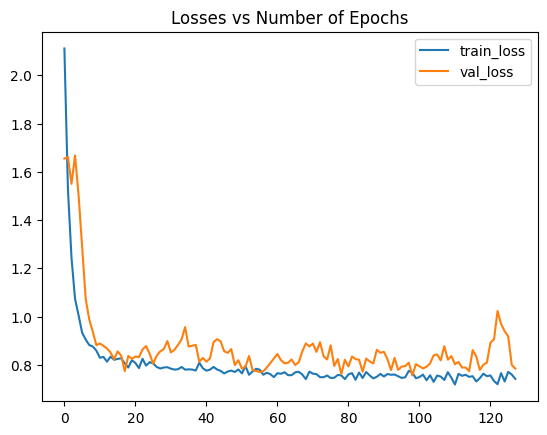

In [16]:
pyplot.plot(df_results["train_loss"], label="train_loss")
pyplot.plot(df_results["val_loss"], label="val_loss")
pyplot.legend()
pyplot.title(f"Losses vs Number of Epochs")

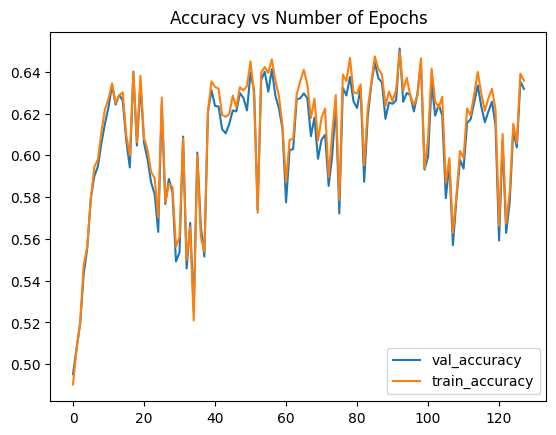

In [17]:
pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
pyplot.plot(df_results["train_accuracy"], label="train_accuracy")
pyplot.title(f"Accuracy vs Number of Epochs")
pyplot.legend()

# 3. Hyperparameter Tuning

In [18]:
params = {
    "learning_rate": [0.1, 0.005, 0.01],
    "optimizer": ["adam", "sgd"],
    "n_layers": [2, 3, 4],
    "is_batch_norm": [True],
    "activation_func": ["relu", "leaky_relu"],
    "n_epochs": [128],
    "batch_size": [8192, 16384],
}

sweep_config = {
    "method": "random",
    "metric": {"name": "loss", "goal": "minimize"},
}

sweep_config["parameters"] = {k: {"values": v} for k, v in params.items()}

In [19]:
wandb.login()

loss_mp = {}

def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        result_df, val_loss, val_acc, chkpt, model = train_node(config)

        # Get test accuracy
        correct = 0
        total = 0

        loader_train = DataLoader(ds_train, batch_size=config["batch_size"], shuffle=True)

        with torch.no_grad():
            for inputs, labels in loader_train:
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_acc = correct / total

        loss_mp[val_loss] = {
            "config": config,
            "result_df": result_df,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "train_acc": train_acc,
            "chkpt": chkpt,
        }

        wandb.log({"loss": val_loss})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
sweep_id = wandb.sweep(sweep_config, project="FAIR_sweep_final_5")
wandb.agent(sweep_id, train_wandb, count=32)

Create sweep with ID: 91vfliy1
Sweep URL: https://wandb.ai/lbypatrick/FAIR_sweep_final_5/sweeps/91vfliy1


wandb: Agent Starting Run: m1pwa0ae with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: sgd
wandb: Currently logged in as: lbypatrick. Use `wandb login --relogin` to force relogin


Epoch [128/128] train_loss: 1.9766,val_loss: 1.9683,val_acc: 0.616,train_acc: 0.6141071428571429


loss,▁
loss,1.96574


wandb: Agent Starting Run: bma2osqc with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7606,val_loss: 0.8041,val_acc: 0.6201666666666666,train_acc: 0.6269285714285714


loss,▁
loss,0.7872


wandb: Agent Starting Run: hq9wp7ji with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7513,val_loss: 0.9822,val_acc: 0.592,train_acc: 0.5935


loss,▁
loss,0.80496


wandb: Agent Starting Run: o6kczskf with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.5218,val_loss: 1.5308,val_acc: 0.6255,train_acc: 0.6313928571428571


loss,▁
loss,1.51634


wandb: Agent Starting Run: usvhd8oa with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7342,val_loss: 0.8064,val_acc: 0.5763333333333334,train_acc: 0.5911785714285714


loss,▁
loss,0.78707


wandb: Agent Starting Run: acsfdupb with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9354,val_loss: 0.9304,val_acc: 0.6381666666666667,train_acc: 0.6402857142857142


loss,▁
loss,0.94472


wandb: Agent Starting Run: kmzo5odh with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7568,val_loss: 0.7368,val_acc: 0.6378333333333334,train_acc: 0.6456428571428572


loss,▁
loss,0.77536


wandb: Agent Starting Run: z3vds6tk with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 2.3894,val_loss: 2.3717,val_acc: 0.5243333333333333,train_acc: 0.5223571428571429


loss,▁
loss,2.37489


wandb: Agent Starting Run: 9732dw73 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9123,val_loss: 0.9152,val_acc: 0.6383333333333333,train_acc: 0.64475


loss,▁
loss,0.93113


wandb: Agent Starting Run: qyr29nb3 with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9231,val_loss: 0.9128,val_acc: 0.6351666666666667,train_acc: 0.6415357142857143


loss,▁
loss,0.93985


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fshwh7fn with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8969,val_loss: 0.9914,val_acc: 0.5918333333333333,train_acc: 0.6034642857142857


loss,▁
loss,1.01635


wandb: Agent Starting Run: ngdfykck with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9298,val_loss: 0.9186,val_acc: 0.645,train_acc: 0.642


loss,▁
loss,0.93541


wandb: Agent Starting Run: r5di0rif with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9204,val_loss: 0.9188,val_acc: 0.6406666666666667,train_acc: 0.6446071428571428


loss,▁
loss,0.93197


wandb: Agent Starting Run: 5hzmu222 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 1.1452,val_loss: 1.1984,val_acc: 0.6348333333333334,train_acc: 0.6475714285714286


loss,▁
loss,1.20267


wandb: Agent Starting Run: 6chcyhem with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 1.1760,val_loss: 1.2456,val_acc: 0.5765,train_acc: 0.5833214285714285


loss,▁
loss,1.26396


wandb: Agent Starting Run: 7tduvs0m with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7586,val_loss: 0.8614,val_acc: 0.5705,train_acc: 0.57675


loss,▁
loss,0.78928


wandb: Agent Starting Run: 1x436jxp with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.9130,val_loss: 1.0411,val_acc: 0.6065,train_acc: 0.6178571428571429


loss,▁
loss,0.98133


wandb: Agent Starting Run: rrdegebp with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.9726,val_loss: 1.9671,val_acc: 0.6053333333333333,train_acc: 0.6014642857142857


loss,▁
loss,1.97525


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8p3xcklz with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.9278,val_loss: 1.2760,val_acc: 0.5231666666666667,train_acc: 0.5302857142857142


loss,▁
loss,1.06103


wandb: Agent Starting Run: d2u6dnr2 with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8934,val_loss: 0.9371,val_acc: 0.6298333333333334,train_acc: 0.6517857142857143


loss,▁
loss,0.98036


wandb: Agent Starting Run: n6vvvksv with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.5567,val_loss: 1.5264,val_acc: 0.6275,train_acc: 0.6285357142857143


loss,▁
loss,1.52225


wandb: Agent Starting Run: 7zx8900f with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.5329,val_loss: 1.5464,val_acc: 0.618,train_acc: 0.6213928571428572


loss,▁
loss,1.53449


wandb: Agent Starting Run: iohiquwy with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7521,val_loss: 0.7962,val_acc: 0.6423333333333333,train_acc: 0.6362142857142857


loss,▁
loss,0.78306


wandb: Agent Starting Run: 3c2gxlof with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8914,val_loss: 0.9584,val_acc: 0.6175,train_acc: 0.6395


loss,▁
loss,0.97195


wandb: Agent Starting Run: ryz423pp with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 1.1764,val_loss: 1.2332,val_acc: 0.6453333333333333,train_acc: 0.6449642857142858


loss,▁
loss,1.23698


wandb: Agent Starting Run: 5dodm1fj with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 1.1483,val_loss: 1.2576,val_acc: 0.6288333333333334,train_acc: 0.6348571428571429


loss,▁
loss,1.28602


wandb: Agent Starting Run: 0fiix3o5 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9250,val_loss: 0.9166,val_acc: 0.6406666666666667,train_acc: 0.6409285714285714


loss,▁
loss,0.93142


wandb: Agent Starting Run: 2umksr6g with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8694,val_loss: 0.9720,val_acc: 0.626,train_acc: 0.6394285714285715


loss,▁
loss,0.98159


wandb: Agent Starting Run: 996xinx6 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 2.4080,val_loss: 2.4172,val_acc: 0.4876666666666667,train_acc: 0.4848928571428571


loss,▁
loss,2.40215


wandb: Agent Starting Run: 7l3fbptl with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8024,val_loss: 0.9603,val_acc: 0.5646666666666667,train_acc: 0.5721071428571428


loss,▁
loss,0.8872


wandb: Agent Starting Run: 7plffatk with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 1.1279,val_loss: 1.3680,val_acc: 0.539,train_acc: 0.5486785714285715


loss,▁
loss,1.29745


wandb: Agent Starting Run: e7sp8hk1 with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 16384
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7643,val_loss: 0.7797,val_acc: 0.6298333333333334,train_acc: 0.6371428571428571


loss,▁
loss,0.79214


In [21]:
cleaned_loss_mp = {}

for k, v in loss_mp.items():
    v["chkpt"]["params"] = dict(v["chkpt"]["params"])
    v["config"] = dict(v["config"])

    cleaned_loss_mp[k] = v

In [22]:
torch.save(cleaned_loss_mp, "data/sweep_result_loss_mp_fast_final_5.pickle")